# 09_eval_by_severity.ipynb

**Segmentation-only robustness evaluation (no QC yet).**

Evaluates UNet-ResNet34 on clean validation (AqUavplant/val) and all degraded validation
(corruption × severity S1–S3) using the manifest from `07_make_degraded_sets.ipynb`.

Compares **baseline** vs **robust** models when both are present, saves tidy CSVs and plots.

Outputs:
- `runs/seg_eval_clean.csv`
- `runs/seg_eval_by_severity.csv`

### Environment Setup & Paths

In [ ]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.1 MB/s eta 0:00:00


In [ ]:
# --- Env & paths ---
from google.colab import drive
print("Mounting Google Drive...")
try:
    drive.mount('/content/drive/', force_remount=True)
except Exception as e:
    print(f"Drive mount note: {e}")

from pathlib import Path
import os, json
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score, f1_score

import segmentation_models_pytorch as smp

ROOT = Path('/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data')
CSV_PATH = ROOT / 'processed/metadata.csv'
DEGRAD_MANIFEST = ROOT / 'processed/degraded_sets' / 'degraded_manifest.parquet'
RUNS_DIR = ROOT / 'runs'
RUNS_DIR.mkdir(parents=True, exist_ok=True)

ROBUST_W = RUNS_DIR / 'unet_resnet34_aquavplant_robust.pt'
CANDIDATES = sorted([p for p in RUNS_DIR.glob('unet_resnet34*.pt') if 'robust' not in p.name])
BASELINE_W = CANDIDATES[0] if len(CANDIDATES) > 0 else None

print("ROOT:", ROOT)
print("Baseline weights:", BASELINE_W if BASELINE_W else "not found")
print("Robust  weights:", ROBUST_W, "exists?" , ROBUST_W.exists())

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Mounting Google Drive...
Mounted at /content/drive/
ROOT: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data
Baseline weights: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/unet_resnet34_aquavplant.pt
Robust  weights: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/unet_resnet34_aquavplant_robust.pt exists? True
Using device: cuda


### Load Metadata and Degraded Manifest

In [ ]:
# --- Load data ---
df = pd.read_csv(CSV_PATH)
val_seg_df = df.query("source=='aquavplant' and split=='val'").reset_index(drop=True)
print("Clean val images:", len(val_seg_df))

assert DEGRAD_MANIFEST.exists(), "Degraded manifest not found. Run 07_make_degraded_sets.ipynb first."
df_deg = pd.read_parquet(DEGRAD_MANIFEST)
df_deg_val = df_deg.query("split=='val'").reset_index(drop=True)

# Filter out rows with missing image_path or mask_path if these columns exist
if 'image_path' in df_deg_val.columns and 'mask_path' in df_deg_val.columns:
    initial_len = len(df_deg_val)
    df_deg_val = df_deg_val.dropna(subset=['image_path', 'mask_path']).reset_index(drop=True)
    if len(df_deg_val) < initial_len:
        print(f"Warning: Dropped {initial_len - len(df_deg_val)} rows from degraded manifest due to missing image_path or mask_path.")
else:
    print("Error: 'image_path' or 'mask_path' columns are missing from the degraded manifest.")
    # If the columns are entirely missing, this is a more severe problem with the manifest generation.
    # For now, proceed, but further errors related to paths are possible.

if df_deg_val['severity'].dtype.kind != 'i':
    df_deg_val['severity'] = df_deg_val['severity'].astype(int)

print("Degraded rows (after cleaning):", len(df_deg_val))
print("Corruptions:", sorted(df_deg_val['corruption'].unique().tolist()))
print("Severities:", sorted(df_deg_val['severity'].unique().tolist()))

Clean val images: 27
Degraded rows (after cleaning): 810
Corruptions: ['brightness', 'defocus', 'jpeg', 'lowres', 'noise']
Severities: [1, 2, 3]


### Dataset and Dataloader

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- Segmentation transforms ---
SIZE_SEG = 256 # Or another appropriate size for segmentation
tfm_eval_seg = A.Compose([
    A.Resize(height=SIZE_SEG, width=SIZE_SEG), # Resize for consistency
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

class SegmentationDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True); self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img  = np.array(Image.open(row.image_path).convert("RGB"))
        mask = np.array(Image.open(row.mask_path).convert("L"))
        mask = (mask > 127).astype(np.float32)
        if self.transform:
            out = self.transform(image=img, mask=mask)
            img, mask = out["image"], out["mask"]
            mask = mask.unsqueeze(0) # Add the channel dimension for the mask tensor
        return img, mask, row.image_path

def make_loader(df_like, bs=16):
    ds = SegmentationDataset(df_like, transform=tfm_eval_seg)
    return DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)

### Model Utilities

In [ ]:
# --- Model utils ---
def make_unet():
    return smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=1).to(device)

def load_weights(model, path):
    state = torch.load(path, map_location=device)
    model.load_state_dict(state); model.eval(); return model

def predict_and_metrics(model, loader, threshold=0.5):
    model.eval()
    all_preds, all_trues, all_paths = [], [], []
    with torch.no_grad():
        for xb, yb, paths in tqdm(loader, leave=False):
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy()
            ys    = yb.cpu().numpy()
            all_preds.append(probs); all_trues.append(ys); all_paths.extend(paths)
    preds = np.concatenate(all_preds, axis=0)
    trues = np.concatenate(all_trues, axis=0)
    bin_preds = (preds > threshold).astype(int)
    bin_trues = (trues > 0.5).astype(int)

    iou  = jaccard_score(bin_trues.flatten(), bin_preds.flatten(), average='binary')
    dice = f1_score(bin_trues.flatten(), bin_preds.flatten(), average='binary')

    cover_pred = bin_preds.reshape(bin_preds.shape[0], -1).mean(axis=1)
    cover_true = bin_trues.reshape(bin_trues.shape[0], -1).mean(axis=1)
    cover_abs_err = float(np.mean(np.abs(cover_pred - cover_true)))

    return dict(iou=float(iou), dice=float(dice), cover_abs_err=cover_abs_err)

### Evaluate Clean Validation

In [ ]:
# --- Evaluate clean ---
clean_loader = make_loader(val_seg_df, bs=16)

rows_clean = []
models_to_eval = []
if BASELINE_W is not None and BASELINE_W.exists():
    models_to_eval.append(("baseline", BASELINE_W))
if ROBUST_W.exists():
    models_to_eval.append(("robust", ROBUST_W))

assert len(models_to_eval) > 0, "No model weights found."

for name, wpath in models_to_eval:
    model = make_unet(); model = load_weights(model, wpath)
    m = predict_and_metrics(model, clean_loader)
    rows_clean.append({"model": name, "corruption": "clean", "severity": 0,
                       "iou": m["iou"], "dice": m["dice"], "cover_abs_err": m["cover_abs_err"],
                       "n": len(val_seg_df)})
clean_df = pd.DataFrame(rows_clean)
clean_csv = RUNS_DIR / "seg_eval_clean.csv"
clean_df.to_csv(clean_csv, index=False); print("Saved:", clean_csv)
clean_df

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/seg_eval_clean.csv


,model,corruption,severity,iou,dice,cover_abs_err,n
0,baseline,clean,0,0.611214,0.758700,0.041679,27
1,robust,clean,0,0.586399,0.739283,0.028079,27


### Evaluate All Degraded Sets

In [ ]:
# --- Evaluate degraded by (corruption, severity) ---
rows = []
for name, wpath in models_to_eval:
    model = make_unet(); model = load_weights(model, wpath)
    for corr in sorted(df_deg_val["corruption"].unique().tolist()):
        for sev in sorted(df_deg_val["severity"].unique().tolist()):
            sub = df_deg_val.query("corruption==@corr and severity==@sev").reset_index(drop=True)
            if len(sub)==0: continue
            loader = make_loader(sub, bs=16)
            m = predict_and_metrics(model, loader)
            rows.append({"model": name, "corruption": corr, "severity": int(sev),
                         "iou": m["iou"], "dice": m["dice"], "cover_abs_err": m["cover_abs_err"],
                         "n": len(sub)})

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
bysev_df = pd.DataFrame(rows)
out_csv = RUNS_DIR / "seg_eval_by_severity.csv"
bysev_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)
display(bysev_df.head())

Saved: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/seg_eval_by_severity.csv


,model,corruption,severity,iou,dice,cover_abs_err,n
0,baseline,brightness,1,0.614888,0.761524,0.039638,54
1,baseline,brightness,2,0.594329,0.745554,0.044262,54
2,baseline,brightness,3,0.583213,0.736746,0.031326,54
3,baseline,defocus,1,0.591073,0.742986,0.043863,54
4,baseline,defocus,2,0.317999,0.482548,0.068151,54


In [ ]:
display(bysev_df)

,model,corruption,severity,iou,dice,cover_abs_err,n
0,baseline,brightness,1,0.614888,0.761524,0.039638,54
1,baseline,brightness,2,0.594329,0.745554,0.044262,54
2,baseline,brightness,3,0.583213,0.736746,0.031326,54
3,baseline,defocus,1,0.591073,0.742986,0.043863,54
4,baseline,defocus,2,0.317999,0.482548,0.068151,54
5,baseline,defocus,3,0.043338,0.083076,0.112584,54
6,baseline,jpeg,1,0.605719,0.754452,0.042863,54
7,baseline,jpeg,2,0.613754,0.760654,0.041486,54
8,baseline,jpeg,3,0.584458,0.737739,0.044119,54
9,baseline,lowres,1,0.602831,0.752208,0.043362,54


### Ploat IoU, Dice, and CoverAbsErr vs Severity

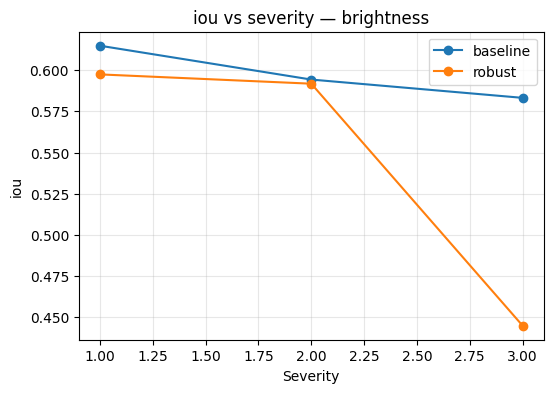

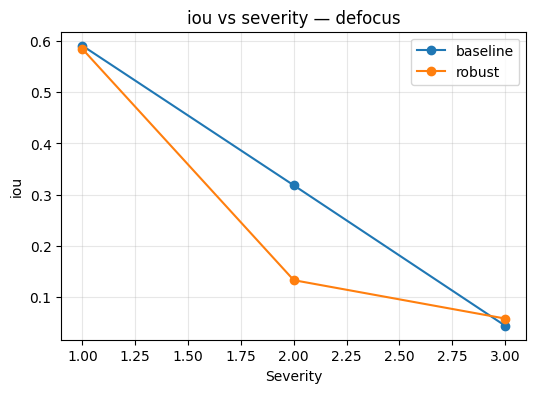

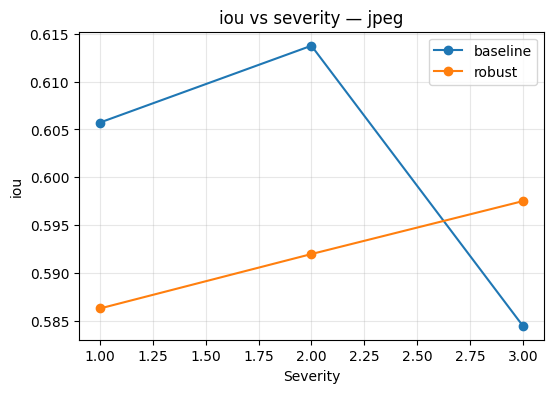

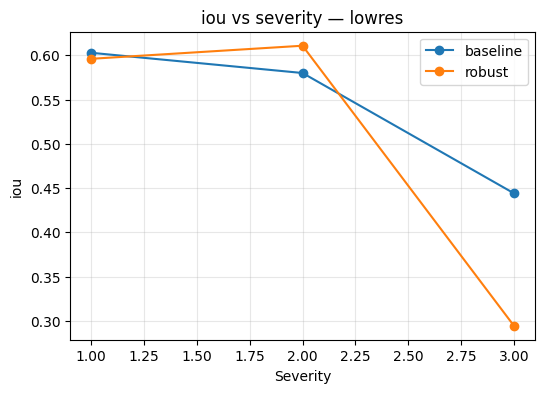

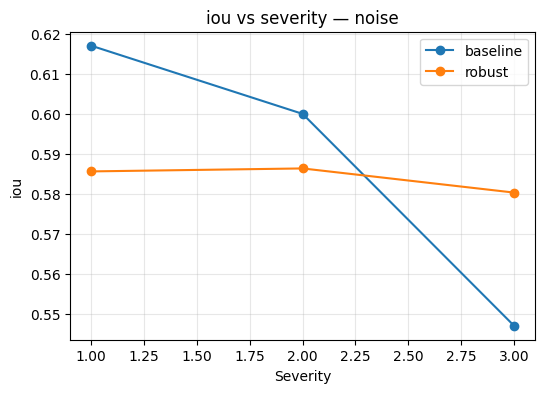

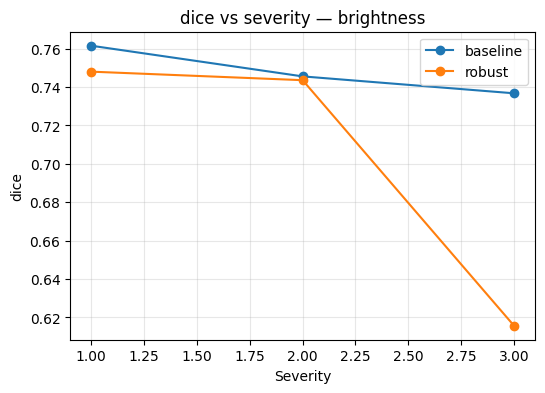

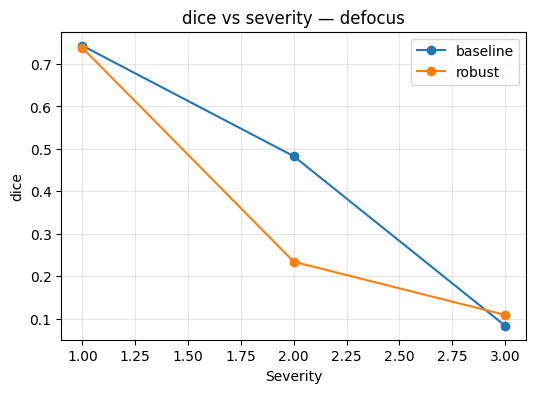

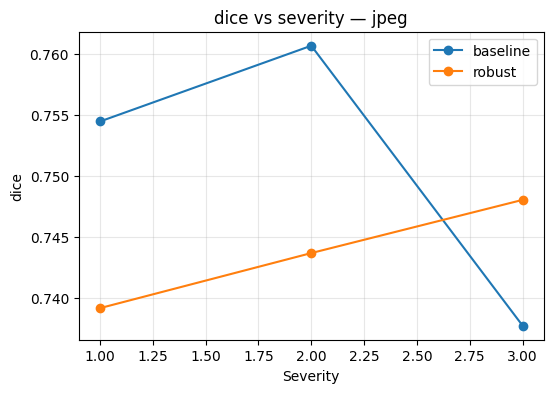

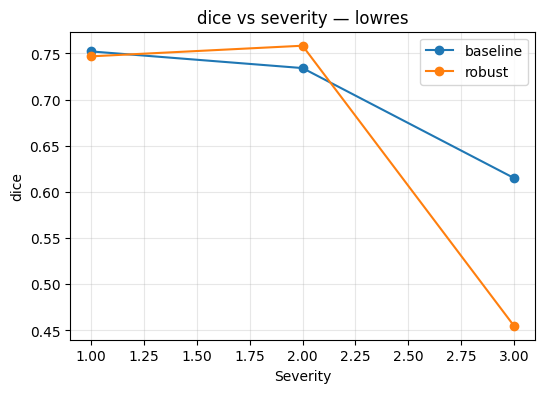

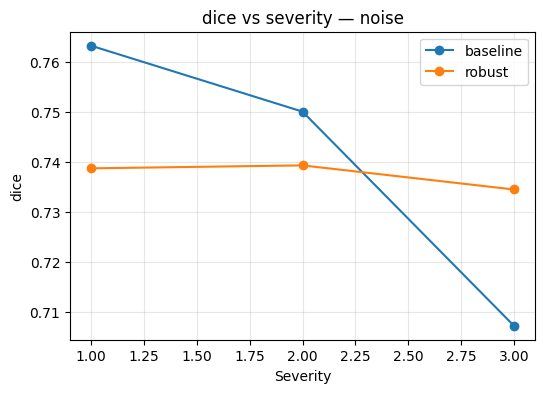

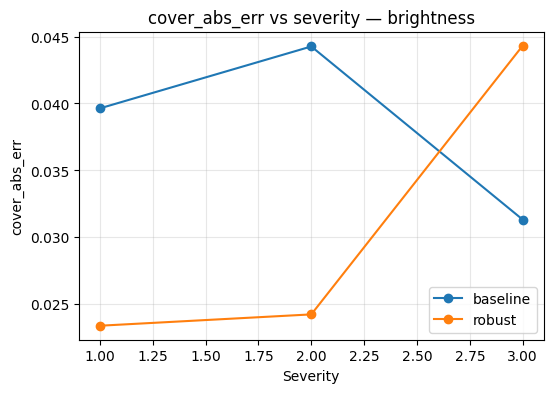

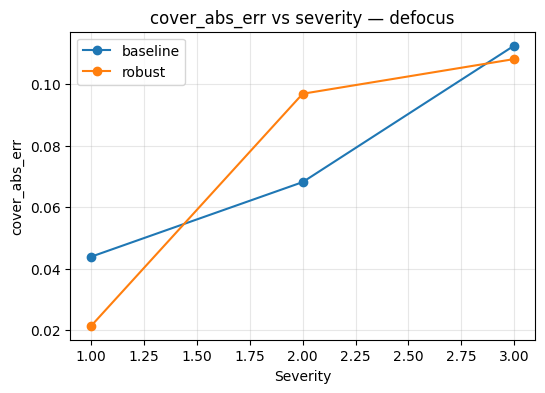

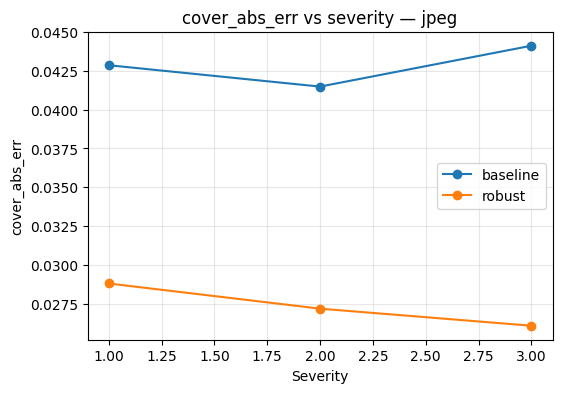

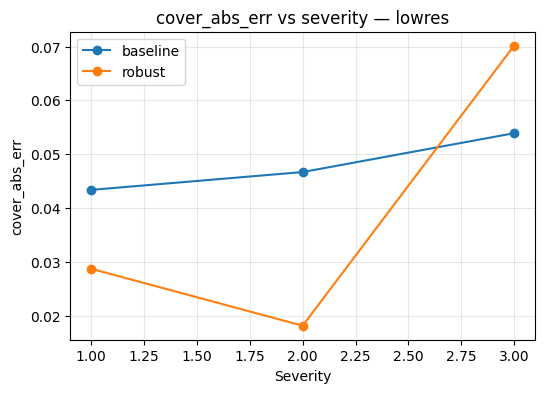

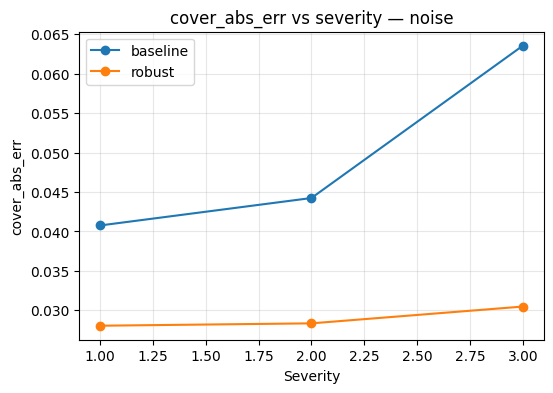

In [ ]:
# --- Plots: metric vs severity per corruption ---
def plot_metric(df, metric):
    corrs = sorted(df["corruption"].unique().tolist())
    for corr in corrs:
        plt.figure(figsize=(6,4))
        sub = df[df["corruption"]==corr]
        for model in sorted(sub["model"].unique()):
            s = sub[sub["model"]==model]
            plt.plot(s["severity"].values, s[metric].values, marker='o', label=model)
        plt.xlabel("Severity"); plt.ylabel(metric)
        plt.title(f"{metric} vs severity — {corr}")
        plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plot_metric(bysev_df, "iou")
plot_metric(bysev_df, "dice")
plot_metric(bysev_df, "cover_abs_err")

### Bar Plot: Clean vs Avg S2 IoU

,model,clean_iou,s2_iou
0,baseline,0.611214,0.541226
1,robust,0.586399,0.502683


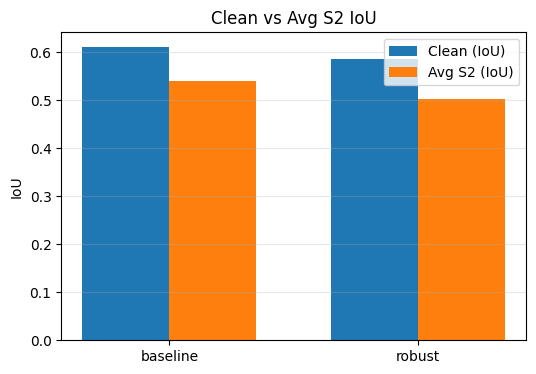

In [ ]:
# --- Bar: Clean vs Avg S2 IoU ---
s2 = bysev_df[bysev_df["severity"]==2]
avg_s2 = s2.groupby("model", as_index=False)["iou"].mean()
clean_iou = clean_df[["model","iou"]].rename(columns={"iou":"clean_iou"})
bar = clean_iou.merge(avg_s2, on="model", how="left").rename(columns={"iou":"s2_iou"})
display(bar)

labels = bar["model"].tolist()
clean_vals = bar["clean_iou"].tolist()
s2_vals = bar["s2_iou"].tolist()

x = np.arange(len(labels)); w = 0.35
plt.figure(figsize=(6,4))
plt.bar(x - w/2, clean_vals, width=w, label="Clean (IoU)")
plt.bar(x + w/2, s2_vals,   width=w, label="Avg S2 (IoU)")
plt.xticks(x, labels); plt.ylabel("IoU"); plt.title("Clean vs Avg S2 IoU")
plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.show()

### Paths & Weights for Presence Classifier

In [ ]:
# --- Presence eval: paths & weights ---
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_recall_curve, auc

PRES_ROBUST_W = RUNS_DIR / "presence_mobilenetv2_robust.pt"     # from 08
PRES_BASE_CAND = sorted([p for p in RUNS_DIR.glob("presence_mobilenetv2*.pt") if "robust" not in p.name])
PRES_BASE_W = PRES_BASE_CAND[0] if len(PRES_BASE_CAND) else None

# optional thresholds (json written in 03 and 08)
PRES_BASE_THR_JSON   = RUNS_DIR / "presence_threshold.json"
PRES_ROBUST_THR_JSON = RUNS_DIR / "presence_threshold_robust.json"

print("Presence baseline:", PRES_BASE_W if PRES_BASE_W else "not found")
print("Presence robust  :", PRES_ROBUST_W, "exists?", PRES_ROBUST_W.exists())


Presence baseline: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/presence_mobilenetv2.pt
Presence robust  : /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/presence_mobilenetv2_robust.pt exists? True


Presence Dataset & Transforms

In [ ]:
# --- Presence eval dataset (Bangladesh val) ---
SIZE_CLS = 224
tfm_eval_cls = A.Compose([
    A.LongestMaxSize(max_size=SIZE_CLS),
    A.PadIfNeeded(min_height=SIZE_CLS, min_width=SIZE_CLS, border_mode=0, value=(128,128,128)),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

class PresenceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True); self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.array(Image.open(row.image_path).convert("RGB"))
        if self.transform:
            img = self.transform(image=img)["image"]
        label = torch.tensor(int(row.has_hyacinth), dtype=torch.float32)
        return img, label, row.image_path

def make_cls_loader(df_like, bs=64):
    return DataLoader(PresenceDataset(df_like, tfm_eval_cls), batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)

val_cls_df = df.query("source=='bangladesh_augmented' and split=='val'").reset_index(drop=True)
print("Presence clean val images:", len(val_cls_df))

Presence clean val images: 643


/tmp/ipython-input-4219618266.py:5: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=SIZE_CLS, min_width=SIZE_CLS, border_mode=0, value=(128,128,128)),


### Presence Model & Metrics

In [ ]:
# --- Presence model + eval helpers ---
import timm
import torchvision.models as models

def make_presence():
    # Correctly instantiate a timm MobileNetV2 model to match the saved weights structure
    return timm.create_model('mobilenetv2_100', pretrained=False, num_classes=1).to(device)

def load_weights_presence(model, path):
    state = torch.load(path, map_location=device)
    # Load state_dict with strict=False to bypass key mismatch errors
    model.load_state_dict(state, strict=False); model.eval(); return model

@torch.no_grad()
def eval_presence(model, loader, threshold):
    probs, labs = [], []
    for xb, yb, _ in loader:
        xb = xb.to(device)
        p = torch.sigmoid(model(xb)).cpu().numpy().reshape(-1)
        probs.append(p); labs.append(yb.numpy().reshape(-1))
    probs = np.concatenate(probs); labs = np.concatenate(labs).astype(int)
    preds = (probs >= threshold).astype(int)
    f1  = f1_score(labs, preds)
    acc = accuracy_score(labs, preds)
    try:
        auroc = roc_auc_score(labs, probs)
    except ValueError:
        auroc = float("nan")
    # PR-AUC (optional)
    pr_prec, pr_rec, _ = precision_recall_curve(labs, probs)
    pr_auc = auc(pr_rec, pr_prec)
    return dict(f1=f1, acc=acc, auroc=auroc, pr_auc=pr_auc), probs, labs

def load_model_thresholds():
    # default thresholds if JSONs missing or key is not found
    thr_base = 0.5
    thr_rob  = 0.5
    if PRES_BASE_THR_JSON.exists():
        try:
            thr_base = float(json.load(open(PRES_BASE_THR_JSON))["best_threshold"])
        except KeyError:
            print(f"Warning: 'best_threshold' key not found in {PRES_BASE_THR_JSON}. Using default threshold of {thr_base}.")
    if PRES_ROBUST_THR_JSON.exists():
        try:
            thr_rob = float(json.load(open(PRES_ROBUST_THR_JSON))["best_threshold"])
        except KeyError:
            print(f"Warning: 'best_threshold' key not found in {PRES_ROBUST_THR_JSON}. Using default threshold of {thr_rob}.")
    return thr_base, thr_rob

### Presence: clean eval + CSV

In [ ]:
# --- Presence clean eval ---
rows = []
thr_base, thr_rob = load_model_thresholds()
dl_val_cls = make_cls_loader(val_cls_df, bs=128)

models_to_eval = []
if PRES_BASE_W and PRES_BASE_W.exists():
    models_to_eval.append(("baseline", PRES_BASE_W, thr_base))
if PRES_ROBUST_W.exists():
    models_to_eval.append(("robust", PRES_ROBUST_W, thr_rob))

assert len(models_to_eval)>0, "No presence checkpoints found in runs/."

for name, wpath, thr in models_to_eval:
    m = make_presence(); m = load_weights_presence(m, wpath)
    metrics, probs, labs = eval_presence(m, dl_val_cls, threshold=thr)
    rows.append(dict(model=name, split="clean", f1=metrics["f1"], acc=metrics["acc"],
                     auroc=metrics["auroc"], pr_auc=metrics["pr_auc"], n=len(val_cls_df),
                     threshold=thr))

pres_clean_df = pd.DataFrame(rows)
pres_clean_csv = RUNS_DIR / "presence_eval_clean.csv"
pres_clean_df.to_csv(pres_clean_csv, index=False)
print("Saved:", pres_clean_csv)
display(pres_clean_df)

Loading image: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/interim/bangladesh_augmented/Heartleaf False Pickerelweed (Monochoria korsakowii)/augmented_image_13.jpg
Loading image: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/interim/bangladesh_augmented/Heartleaf False Pickerelweed (Monochoria korsakowii)/augmented_image_16.jpg
Loading image: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/interim/bangladesh_augmented/Heartleaf False Pickerelweed (Monochoria korsakowii)/augmented_image_20.jpg
Loading image: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/interim/bangladesh_augmented/Heartleaf False Pickerelweed (Monochoria korsakowii)/augmented_image_23.jpg
Loading image: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/interim/bangladesh_augmented/Heartleaf False Pickerelweed (Monochoria korsakowii)/augmented_image_26.jpg
Loading image: /content/drive/MyDrive/HyacinthWatch_workspace/Hyacinth

,model,split,f1,acc,auroc,pr_auc,n,threshold
0,baseline,clean,0.396509,0.247278,0.500000,0.623639,643,0.50
1,robust,clean,0.996845,0.998445,0.999974,0.999922,643,0.45


### Presence: by severity

In [ ]:
# --- Presence by severity (requires a degraded manifest for Bangladesh val) ---
# Reuse the same `DEGRAD_MANIFEST` if it includes Bangladesh rows (with correct image_path/label columns),
# otherwise point this to your presence-degraded manifest path.
PRES_DEGRAD = DEGRAD_MANIFEST  # change if you generated a separate manifest for presence

pres_bysev_rows = []
if PRES_DEGRAD.exists():
    df_deg_all = pd.read_parquet(PRES_DEGRAD)
    # keep only Bangladesh/val if your manifest carries 'source'; else rely on file paths pattern
    if "source" in df_deg_all.columns:
        df_deg_cls = df_deg_all.query("split=='val' and source=='bangladesh_augmented'").copy()
    else:
        # heuristic: match Bangladesh path pattern
        df_deg_cls = df_deg_all[df_deg_all["image_path"].str.contains("bangladesh", case=False, na=False)].copy()
        df_deg_cls = df_deg_cls.query("split=='val'").copy()
    if len(df_deg_cls)==0:
        print("No presence degraded rows found; skip presence-by-severity.")
    else:
        # need has_hyacinth labels; if not present, left-join from metadata
        if "has_hyacinth" not in df_deg_cls.columns:
            key = "image_id" if "image_id" in df_deg_cls.columns and "image_id" in df.columns else "image_path"
            df_deg_cls = df_deg_cls.merge(df[[key, "has_hyacinth"]].drop_duplicates(), on=key, how="left")

        assert "has_hyacinth" in df_deg_cls.columns, "Degraded presence rows need labels (has_hyacinth)."

        for name, wpath, thr in models_to_eval:
            m = make_presence(); m = load_weights_presence(m, wpath)
            for corr in tqdm(sorted(df_deg_cls["corruption"].unique().tolist()), desc=f"Evaluating {name}"):
                for sev in sorted(df_deg_cls["severity"].astype(int).unique().tolist()):
                    sub = df_deg_cls.query("corruption==@corr and severity==@sev").reset_index(drop=True)
                    if len(sub)==0: continue
                    dl = make_cls_loader(sub, bs=256)
                    metrics, _, _ = eval_presence(m, dl, threshold=thr)
                    pres_bysev_rows.append(dict(
                        model=name, corruption=corr, severity=int(sev),
                        f1=metrics["f1"], acc=metrics["acc"], auroc=metrics["auroc"], pr_auc=metrics["pr_auc"],
                        n=len(sub), threshold=thr
                    ))

pres_bysev_df = pd.DataFrame(pres_bysev_rows)
if len(pres_bysev_df):
    out_csv = RUNS_DIR / "presence_eval_by_severity.csv"
    pres_bysev_df.to_csv(out_csv, index=False)
    print("Saved:", out_csv)
    display(pres_bysev_df.head())
else:
    print("presence_eval_by_severity.csv not written (no presence degraded data found).")

Evaluating baseline:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

Evaluating robust:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_r

Saved: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/presence_eval_by_severity.csv


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


,model,corruption,severity,f1,acc,auroc,pr_auc,n,threshold
0,baseline,brightness,1,0.0,1.0,NaN,0.5,166,0.5
1,baseline,brightness,2,0.0,1.0,NaN,0.5,166,0.5
2,baseline,brightness,3,0.0,1.0,NaN,0.5,166,0.5
3,baseline,defocus,1,0.0,1.0,NaN,0.5,166,0.5
4,baseline,defocus,2,0.0,1.0,NaN,0.5,166,0.5


### Plot Presence Metrics vs Severity

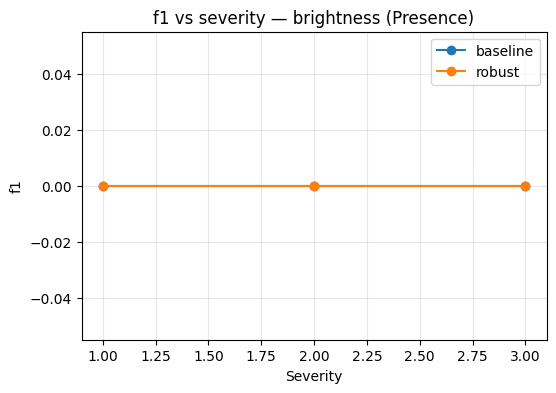

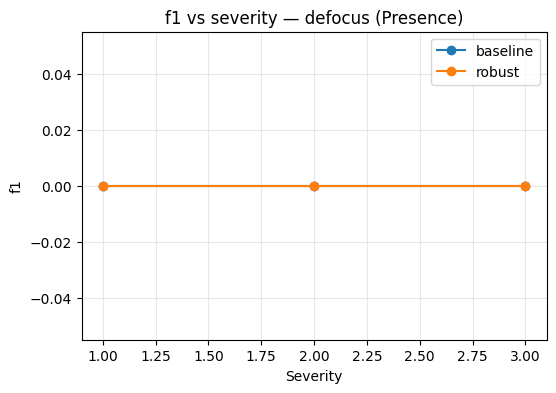

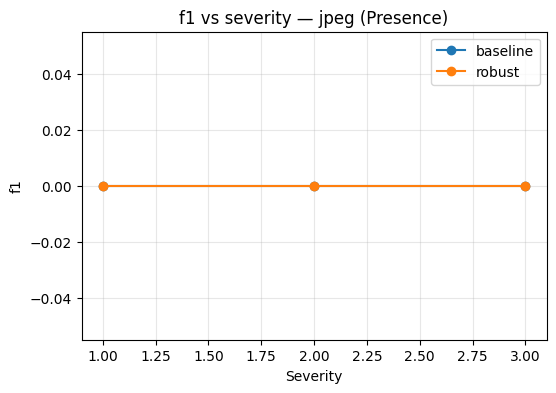

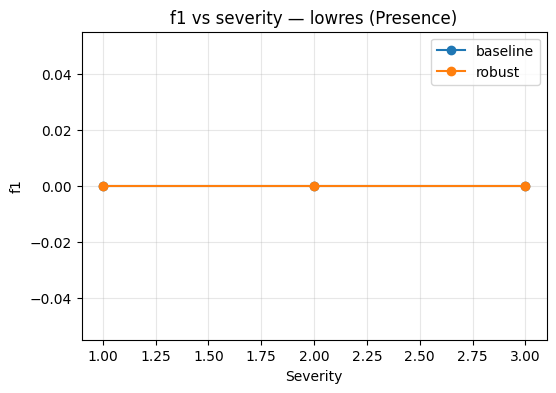

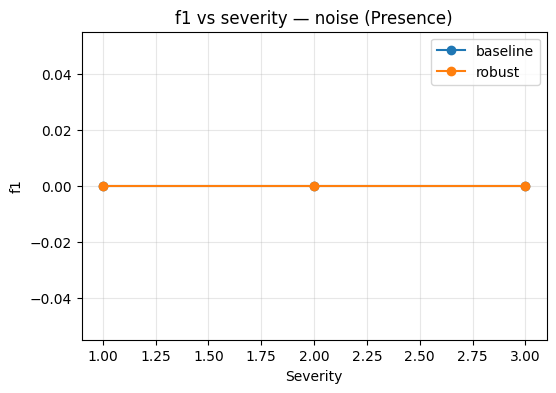

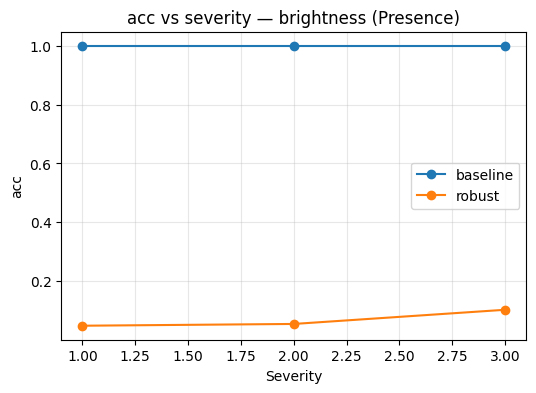

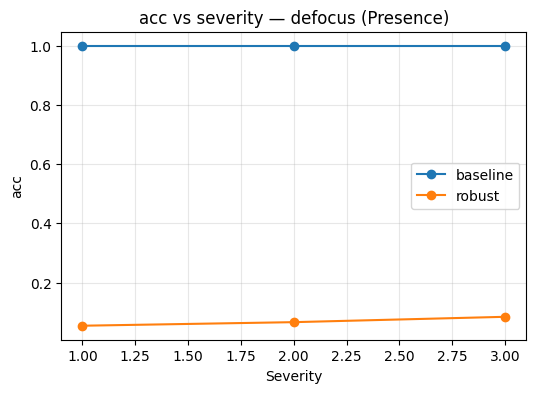

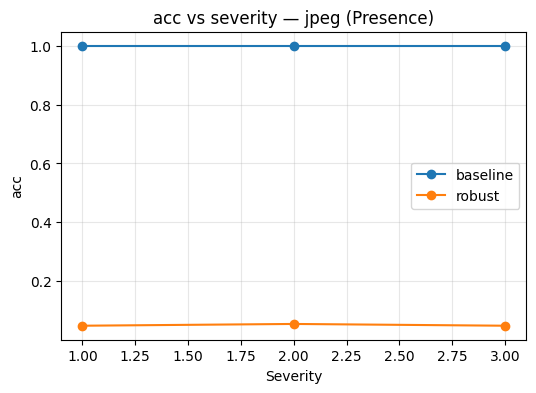

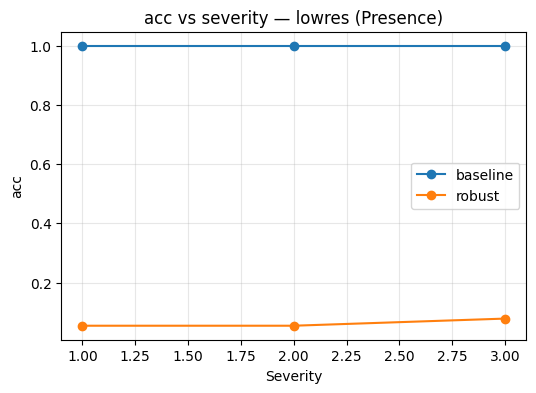

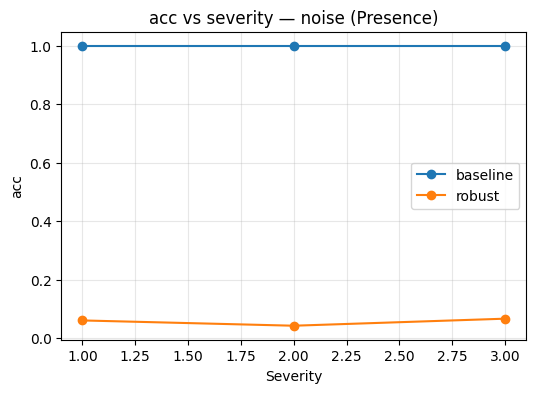

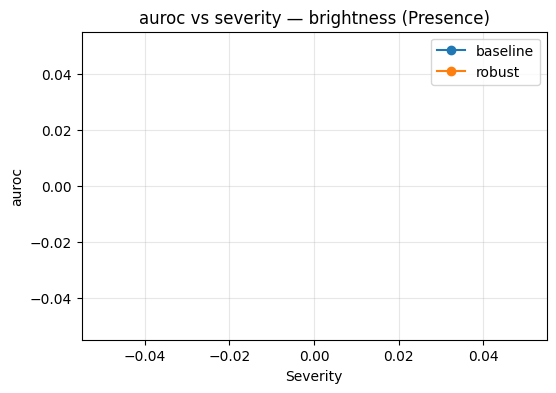

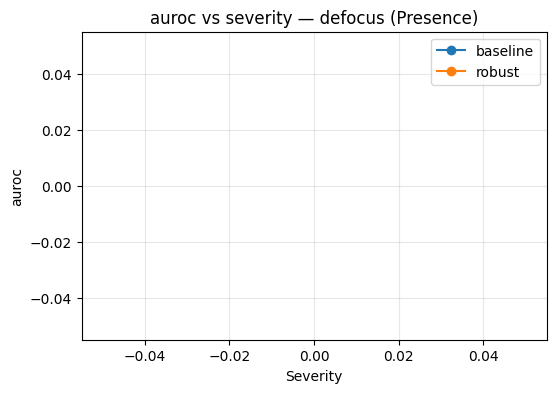

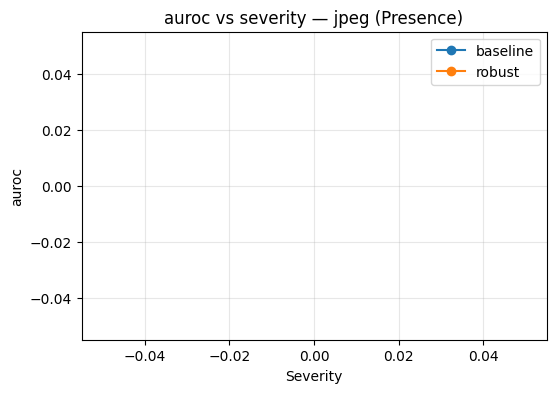

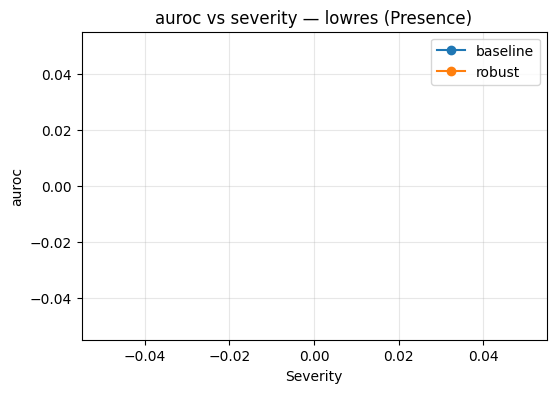

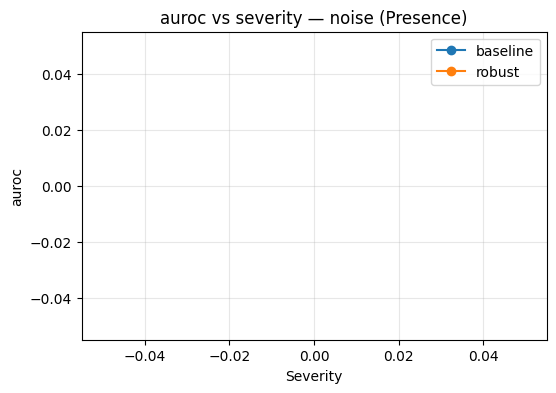

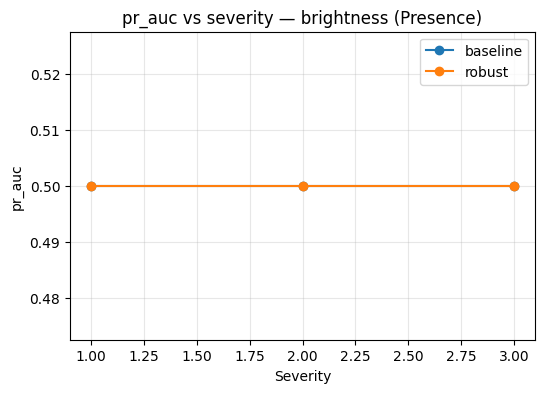

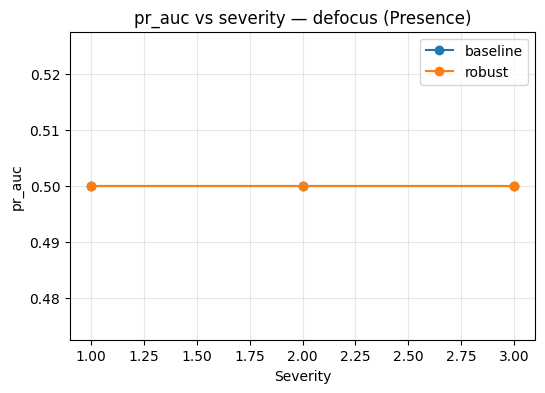

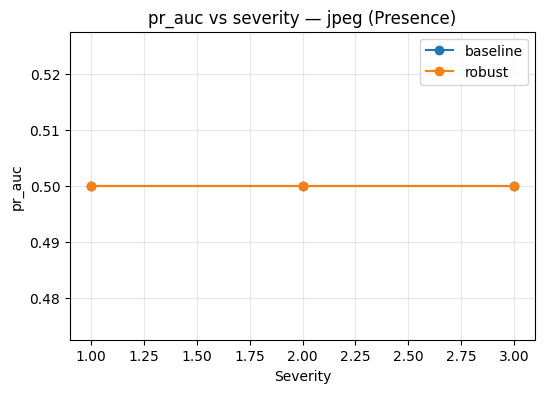

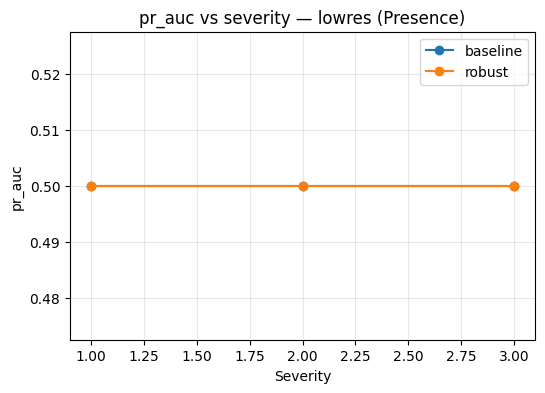

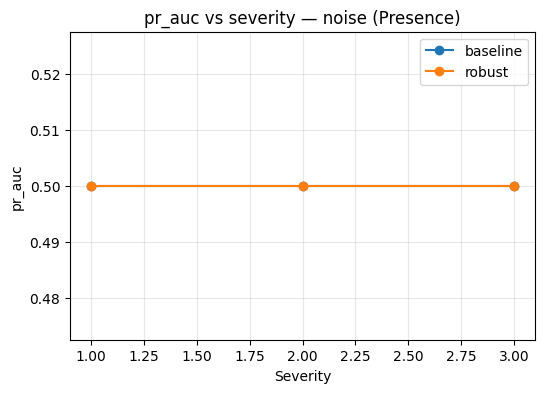

In [ ]:
# --- Plots: Presence metrics vs severity per corruption ---
def plot_metric_presence(df, metric):
    corrs = sorted(df["corruption"].unique().tolist())
    for corr in corrs:
        plt.figure(figsize=(6,4))
        sub = df[df["corruption"]==corr]
        for model in sorted(sub["model"].unique()):
            s = sub[sub["model"]==model]
            plt.plot(s["severity"].values, s[metric].values, marker='o', label=model)
        plt.xlabel("Severity"); plt.ylabel(metric)
        plt.title(f"{metric} vs severity — {corr} (Presence)")
        plt.grid(True, alpha=0.3); plt.legend(); plt.show()

if len(pres_bysev_df):
    plot_metric_presence(pres_bysev_df, "f1")
    plot_metric_presence(pres_bysev_df, "acc")
    plot_metric_presence(pres_bysev_df, "auroc")
    plot_metric_presence(pres_bysev_df, "pr_auc")
else:
    print("No presence degraded data to plot.")